In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

import scipy.linalg as spl

# Function for testing positive definiteness
def is_pos_def(A):
    if np.allclose(A, A.conj().T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

comment = "Fit to covariance in sim"
nb_name = "nb_midpath_dynamo_covmod_sim"

In [2]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)
core.generate_map(target_var_factor = 1)

core.condtab(normsize=10000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble") #model_hist = "ensemble"

In [3]:
core.semivar(model_lags = 20, model = "exponential", max_dist = 20000, lag_length = 100,
             zero_nugget = True, hit_target_var = False)

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 100.0 km
Number of lags: 109
Number of modelling lags: 20

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


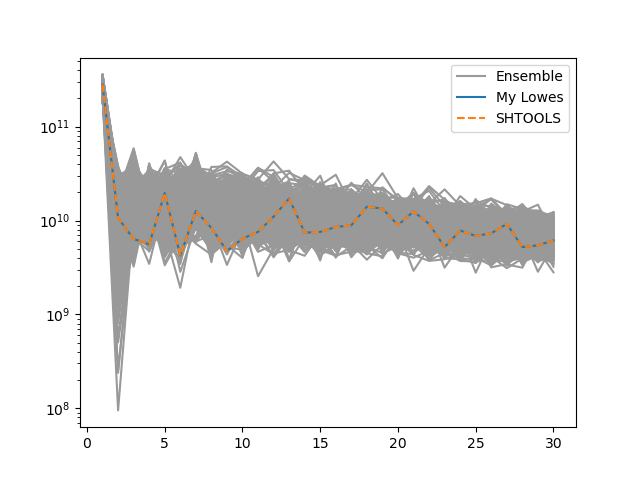

In [4]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

# g ensemble and parameters
g_core_ens = np.genfromtxt("lithosphere_prior/grids/shcoeff_Dynamo/gnm_midpath.dat").T*10**9
g_core_ens = g_core_ens[:mt_util.shc_vec_len(shc_g),:]

a = core.a
c = core.r_cmb
n_max = shc_g

g_cut = g_core_ens[:n_max*(2+n_max),200:] # Truncate g
R = mt_util.lowe_shspec(n_max,c,a,g_cut)

# One spectra for comparison to SHTOOLS
g_cut_one = g_core_ens[:,core.ens_idx][:n_max*(2+n_max)]
R_one = mt_util.lowe_shspec(n_max,c,a,g_cut_one.reshape(-1,1))

# SHTOOLS
ens_cilm_compare = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,), g_cut_one))))
p_spec_compare = pyshtools.gravmag.mag_spectrum(ens_cilm_compare, a, c, degrees = np.arange(1,np.shape(ens_cilm_compare)[1]))

# Spectra
plt.figure()
for i in np.arange(R.shape[1]):
    if i == 0:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6),label="Ensemble")
    else:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6))
plt.semilogy(np.arange(1,n_max+1),R_one,label="My Lowes")
plt.semilogy(np.arange(1,n_max+1),p_spec_compare,linestyle="dashed", label="SHTOOLS")
plt.legend()
plt.show()

# New tapered cov

[]


<IPython.core.display.Javascript object>


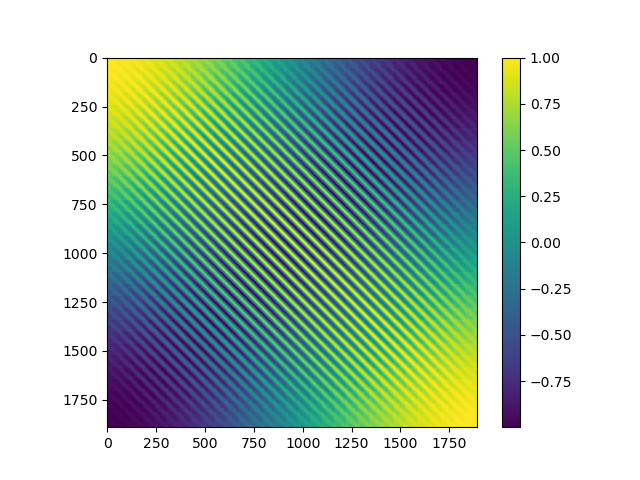

In [5]:
c_angdist = np.cos(mt_util.haversine(1, core.grid_phi.reshape(1,-1), 90-core.grid_theta.reshape(1,-1), 
                              core.grid_phi.reshape(-1,1), 90-core.grid_theta.reshape(-1,1)))

print(c_angdist[c_angdist>1])

plt.figure()
plt.imshow(c_angdist)
plt.colorbar()
plt.show()

In [6]:
tap_to = 500
n_tap = n_max + tap_to

tap_cos = np.cos(np.linspace(0,np.pi,20))+1
tap_cos_norm = ((tap_cos - np.min(tap_cos))/(np.max(tap_cos)-np.min(tap_cos))).reshape(-1,1)

# Compute covariances based on eqn. 11
C_const = (np.arange(1,n_tap+1)+1)/(2*np.arange(1,n_tap+1)+1)

# Pn
Pn = []
for cmu in np.ravel(c_angdist):
    Pn.append(pyshtools.legendre.PlSchmidt(n_tap,cmu)[1:].reshape(-1,1))

Pn = np.array(Pn).reshape((c_angdist.shape[0],c_angdist.shape[1],-1))

# Automate pos def find

<IPython.core.display.Javascript object>


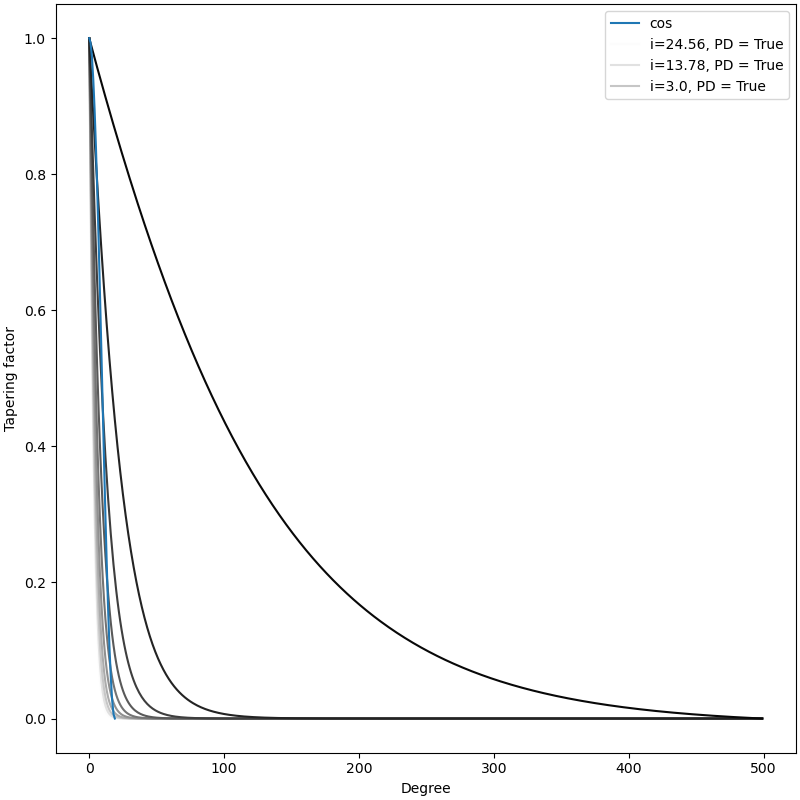

In [7]:
init_lin = 100
N_lin = 10

fig = plt.figure(figsize=(8,8), constrained_layout=True)
gs = fig.add_gridspec(1, 1) 
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(tap_cos_norm,label="cos",zorder=1)
legend_list = ["cos"]
ax1.legend(legend_list)
ax1.set_xlabel('Degree')
ax1.set_ylabel('Tapering factor')
fig.canvas.draw()

try_lin = np.flip(np.round(np.linspace(3,init_lin,N_lin),decimals=2))

for i in try_lin:
    lin_tanh = np.linspace(0.5,i,tap_to)
    tap_tanh = -(np.exp(lin_tanh)-np.exp(-lin_tanh))/(np.exp(lin_tanh)+np.exp(-lin_tanh))
    tap_tanh_norm = ((tap_tanh - np.min(tap_tanh))/(np.max(tap_tanh)-np.min(tap_tanh))).reshape(-1,1)

    R_add = 0.1*R[-1,:]*tap_tanh_norm
    R_tap = np.vstack((R,R_add))

    C_Br = Pn@(C_const.reshape(-1,1)*R_tap)

    C_Br_model = C_Br[:,:,core.ens_idx]
    
    PD = is_pos_def(C_Br_model)
    
    # update plot
    ax1.plot(tap_tanh_norm, color = (i/(init_lin+1),i/(init_lin+1),i/(init_lin+1)),zorder=0)
    if PD:
        legend_list.append('i={}, PD = {}'.format(np.round(i,decimals=2),PD))
    ax1.legend(legend_list)
    
    fig.canvas.draw()
    time.sleep(0.01)

<IPython.core.display.Javascript object>


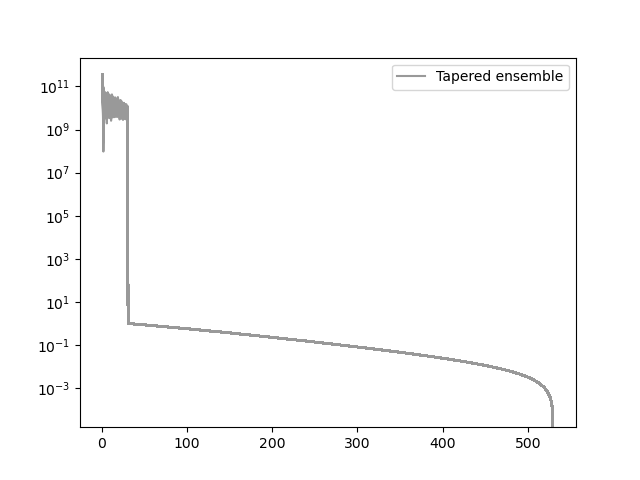

PD:  True


In [7]:
lin_tanh = np.linspace(0.5,3,tap_to)
tap_tanh = -(np.exp(lin_tanh)-np.exp(-lin_tanh))/(np.exp(lin_tanh)+np.exp(-lin_tanh))
tap_tanh_norm = ((tap_tanh - np.min(tap_tanh))/(np.max(tap_tanh)-np.min(tap_tanh))).reshape(-1,1)

#R_add = 0.000001*R[-1,:]*tap_tanh_norm
R_add = np.ones((R[-1,:].shape))*tap_tanh_norm
R_tap = np.vstack((R,R_add))

# Spectra
plt.figure()
for i in np.arange(R_tap.shape[1]):
    if i == 0:
        plt.semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
        #plt.plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
    else:
        plt.semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
        #plt.plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
plt.legend()
plt.show()

C_Br = Pn@(C_const.reshape(-1,1)*R_tap)

C_Br_model = C_Br[:,:,core.ens_idx]

PD = is_pos_def(C_Br_model)
print("PD: ", PD)

In [98]:
i_C_Br_max = np.argmax(np.abs(C_Br),axis=2)

i_C_Br_max.shape

(1891, 1891)

In [99]:
C_Br_max = []

j = 0
for i in np.ravel(i_C_Br_max):
    C_Br_max.append(C_Br.reshape(-1,487)[j,i])
    j +=1
    
C_Br_model = np.array(C_Br_max).reshape(1891,1891)

In [8]:
C_Br_model = np.mean(C_Br,axis=2)

<IPython.core.display.Javascript object>


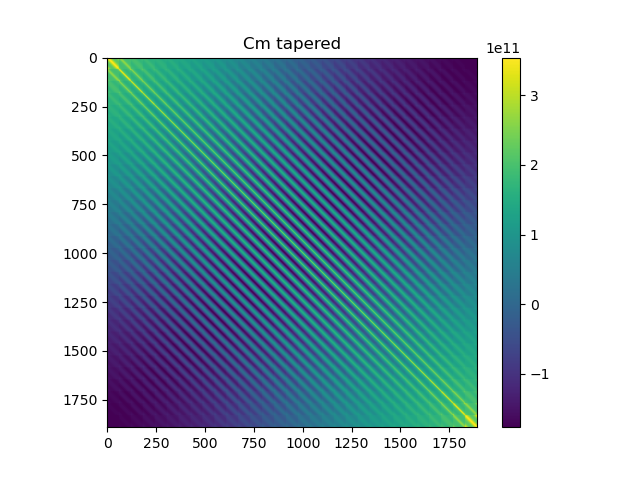

C_Br_model is pos def: True
All eigenvalues > 0: True
Number of negative eigenvalues: 0 / 1891


<IPython.core.display.Javascript object>


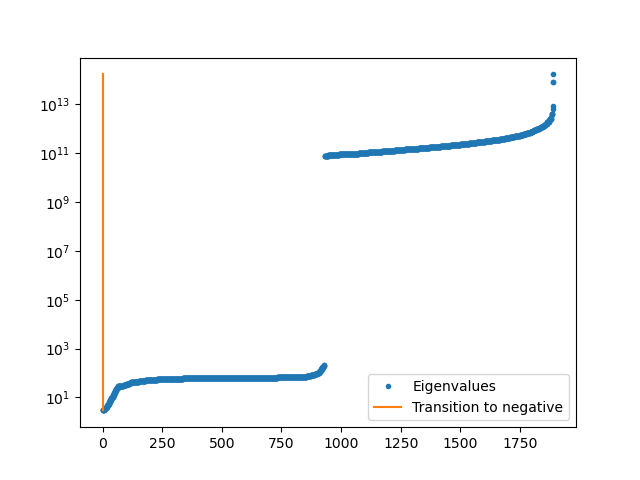

In [9]:
plt.figure()
plt.title("Cm tapered")
plt.imshow(C_Br_model)
plt.colorbar()
plt.show()

# Positive definite covariance?
core_eigval = spl.eigh(C_Br_model, eigvals_only=True)
N_neg_eigval = len(core_eigval[core_eigval<=0])
print("C_Br_model is pos def:", is_pos_def(C_Br_model))
print("All eigenvalues > 0:", np.all(core_eigval>=0))
print("Number of negative eigenvalues:",N_neg_eigval,"/",len(core_eigval))

plt.figure()
plt.semilogy(np.arange(0,len(core_eigval)),core_eigval,'.',label="Eigenvalues")
plt.semilogy(np.ones((100,))*N_neg_eigval,np.linspace(core_eigval[N_neg_eigval],core_eigval[-1],100),label="Transition to negative")
plt.legend()
plt.show()

# Synthetic sat

In [10]:
C_e_const = 2.0

s_sat = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)

s_sat.generate_map(grid_type = "swarm")

s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

# Source truth

In [11]:
s_source = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_source.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.r_cmb, grid_in, calc_sph_d = False)

s_source.generate_map()

# System equations

In [12]:
core.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = C_Br_model)

# SDSSIM

 |----------| 6.2%   realization nr. 0. Counter: 117/1891, Running error magnitude: 6.0

 |O---------| 11.4%   realization nr. 0. Counter: 215/1891, Running error magnitude: 6.0

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 6.0
Run time: 1.036 minutes 
Total elapsed time: 1.036 minutes 
Variance: 873450959997.791
Mean: -72399.121
Max: 2518642.183
Min: -3265623.720
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.006 minutes 
Total elapsed time: 2.043 minutes 
Variance: 370563380174.974
Mean: -42339.016
Max: 4863883.426
Min: -1564792.270
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.002 minutes 
Total elapsed time: 3.045 minutes 
Variance: 424261580931.044
Mean: 12867.701
Max: 2726753.840
Min: -5179765.055
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 59.076 seconds 
Total elapsed time: 4.029 minutes 
Variance: 403030771095.385
Mean: -7290.601
Max: 3144750.899
Min: -2703448.077
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realizatio

 |----------| 8.0%   realization nr. 34. Counter: 152/1891, Running error magnitude: 5.8

 |O---------| 12.9%   realization nr. 34. Counter: 244/1891, Running error magnitude: 5.8

 |OOOOOOOOOO| 100.0%   realization nr. 34. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 58.154 seconds 
Total elapsed time: 34.463 minutes 
Variance: 274399490343.857
Mean: -3071.747
Max: 1674290.105
Min: -1983926.391
Run nr.: 35

 |OOOOOOOOOO| 100.0%   realization nr. 35. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 59.599 seconds 
Total elapsed time: 35.457 minutes 
Variance: 716769109761.535
Mean: -33271.825
Max: 3321626.593
Min: -3986744.894
Run nr.: 36

 |OOOOOOOOOO| 100.0%   realization nr. 36. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 58.755 seconds 
Total elapsed time: 36.436 minutes 
Variance: 323258574800.382
Mean: -33312.636
Max: 2406156.703
Min: -4823191.873
Run nr.: 37

 |OOOOOOOOOO| 100.0%   realization nr. 37. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.021 minutes 
Total elapsed time: 37.456 minutes 
Variance: 226569425781.820
Mean: -13955.095
Max: 1602721.676
Min: -3948131.753
Run nr.: 38

 |OOOOOOOOOO| 100.

 |----------| 6.7%   realization nr. 68. Counter: 127/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 68. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.102 minutes 
Total elapsed time: 1.079 hours 
Variance: 234831051609.241
Mean: 4614.984
Max: 1478489.301
Min: -1596771.671
Run nr.: 69

 |OOOOOOOOOO| 100.0%   realization nr. 69. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.072 minutes 
Total elapsed time: 1.097 hours 
Variance: 205490999038.592
Mean: 18660.950
Max: 1995722.239
Min: -1496774.551
Run nr.: 70

 |OOOOOOOOOO| 100.0%   realization nr. 70. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.026 minutes 
Total elapsed time: 1.114 hours 
Variance: 207265314295.348
Mean: -15603.608
Max: 2036820.520
Min: -1510135.586
Run nr.: 71

 |OOOOOOOOOO| 100.0%   realization nr. 71. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.068 minutes 
Total elapsed time: 1.132 hours 
Variance: 277051198140.292
Mean: 38348.927
Max: 2077145.860
Min: -2425640.451
Run nr.: 72

 |OOOOOOOOOO| 100.0%   realization n

 |----------| 7.0%   realization nr. 102. Counter: 133/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 102. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.005 minutes 
Total elapsed time: 1.644 hours 
Variance: 288476202949.637
Mean: -24965.542
Max: 4226620.535
Min: -2213880.992
Run nr.: 103

 |OOOOOOOOOO| 100.0%   realization nr. 103. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 58.321 seconds 
Total elapsed time: 1.660 hours 
Variance: 208239636086.468
Mean: 17047.886
Max: 1456382.788
Min: -1464065.936
Run nr.: 104

 |OOOOOOOOOO| 100.0%   realization nr. 104. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 57.010 seconds 
Total elapsed time: 1.676 hours 
Variance: 401076765502.295
Mean: 11451.056
Max: 3342173.011
Min: -3346679.720
Run nr.: 105

 |OOOOOOOOOO| 100.0%   realization nr. 105. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 56.504 seconds 
Total elapsed time: 1.692 hours 
Variance: 246463789630.204
Mean: -15032.533
Max: 1427035.621
Min: -1575679.714
Run nr.: 106

 |OOOOOOOOOO| 100.0%   

 |----------| 7.0%   realization nr. 136. Counter: 133/1891, Running error magnitude: 5.7

 |O---------| 12.7%   realization nr. 136. Counter: 241/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 136. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.023 minutes 
Total elapsed time: 2.201 hours 
Variance: 213526391456.342
Mean: -7764.451
Max: 1411073.421
Min: -2348462.317
Run nr.: 137

 |OOOOOOOOOO| 100.0%   realization nr. 137. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 1.028 minutes 
Total elapsed time: 2.218 hours 
Variance: 286792827973.016
Mean: -5622.672
Max: 1581522.369
Min: -1562029.878
Run nr.: 138

 |OOOOOOOOOO| 100.0%   realization nr. 138. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.043 minutes 
Total elapsed time: 2.235 hours 
Variance: 235590349658.504
Mean: -13191.433
Max: 1889284.230
Min: -4193434.028
Run nr.: 139

 |OOOOOOOOOO| 100.0%   realization nr. 139. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.036 minutes 
Total elapsed time: 2.253 hours 
Variance: 315763885217.417
Mean: -31116.129
Max: 2248274.122
Min: -2576747.908
Run nr.: 140

 |OOOOOOOOOO| 100.0%   rea

 |----------| 7.6%   realization nr. 170. Counter: 143/1891, Running error magnitude: 5.6

 |O---------| 13.6%   realization nr. 170. Counter: 258/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 170. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.023 minutes 
Total elapsed time: 2.769 hours 
Variance: 233283524429.120
Mean: 14956.634
Max: 1896659.206
Min: -2235146.335
Run nr.: 171

 |OOOOOOOOOO| 100.0%   realization nr. 171. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.010 minutes 
Total elapsed time: 2.786 hours 
Variance: 566928751913.581
Mean: -82330.274
Max: 1509291.041
Min: -3592359.251
Run nr.: 172

 |OOOOOOOOOO| 100.0%   realization nr. 172. Counter: 1891/1891, Running error magnitude: 5.9
Run time: 1.075 minutes 
Total elapsed time: 2.804 hours 
Variance: 682910694502.923
Mean: -34769.515
Max: 4899015.381
Min: -3894717.978
Run nr.: 173

 |OOOOOOOOOO| 100.0%   realization nr. 173. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.034 minutes 
Total elapsed time: 2.821 hours 
Variance: 218141181620.065
Mean: -21195.083
Max: 4856285.478
Min: -1680707.656
Run nr.: 174

 |OOOOOOOOOO| 100.0%   re

 |----------| 8.9%   realization nr. 204. Counter: 168/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 204. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 40.518 seconds 
Total elapsed time: 3.268 hours 
Variance: 390741065987.556
Mean: -9759.542
Max: 2716293.826
Min: -2538435.421
Run nr.: 205

 |OOOOOOOOOO| 100.0%   realization nr. 205. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 40.342 seconds 
Total elapsed time: 3.279 hours 
Variance: 335910353718.279
Mean: -45095.202
Max: 2806851.900
Min: -1477215.646
Run nr.: 206

 |OOOOOOOOOO| 100.0%   realization nr. 206. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 40.376 seconds 
Total elapsed time: 3.290 hours 
Variance: 231520114278.889
Mean: 27970.709
Max: 1531851.546
Min: -1490963.393
Run nr.: 207

 |OOOOOOOOOO| 100.0%   realization nr. 207. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 43.950 seconds 
Total elapsed time: 3.302 hours 
Variance: 400146464512.405
Mean: 2901.098
Max: 4343281.446
Min: -2990373.739
Run nr.: 208

 |OOOOOOOOOO| 100.0%   r

 |----------| 5.7%   realization nr. 238. Counter: 108/1891, Running error magnitude: 5.5

 |O---------| 10.5%   realization nr. 238. Counter: 199/1891, Running error magnitude: 5.6

 |O---------| 15.5%   realization nr. 238. Counter: 294/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 238. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 48.079 seconds 
Total elapsed time: 3.672 hours 
Variance: 166537008289.515
Mean: -19660.027
Max: 1241788.451
Min: -1483345.799
Run nr.: 239

 |OOOOOOOOOO| 100.0%   realization nr. 239. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 46.560 seconds 
Total elapsed time: 3.685 hours 
Variance: 240813784625.669
Mean: -10132.844
Max: 1408158.167
Min: -1532095.984
Run nr.: 240

 |OOOOOOOOOO| 100.0%   realization nr. 240. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 46.441 seconds 
Total elapsed time: 3.698 hours 
Variance: 198493645468.663
Mean: 2492.222
Max: 1541566.474
Min: -1476503.477
Run nr.: 241

 |OOOOOOOOOO| 100.0%   realization nr. 241. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 44.953 seconds 
Total elapsed time: 3.710 hours 
Variance: 160667930600.403
Mean: -21958.046
Max: 1323076.022
Min: -1241743.735
Run nr.: 242

 |OOOOOOOOOO| 100.0%  

 |----------| 7.7%   realization nr. 272. Counter: 145/1891, Running error magnitude: 5.8

 |O---------| 12.6%   realization nr. 272. Counter: 239/1891, Running error magnitude: 5.8

 |OOOOOOOOOO| 100.0%   realization nr. 272. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 47.302 seconds 
Total elapsed time: 4.095 hours 
Variance: 304302323927.334
Mean: -38757.914
Max: 3651172.891
Min: -1574222.897
Run nr.: 273

 |OOOOOOOOOO| 100.0%   realization nr. 273. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 43.606 seconds 
Total elapsed time: 4.107 hours 
Variance: 221222048260.448
Mean: 24553.138
Max: 4873330.486
Min: -1462195.746
Run nr.: 274

 |OOOOOOOOOO| 100.0%   realization nr. 274. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 42.571 seconds 
Total elapsed time: 4.119 hours 
Variance: 248245828438.927
Mean: 56204.059
Max: 1467742.015
Min: -1379546.538
Run nr.: 275

 |OOOOOOOOOO| 100.0%   realization nr. 275. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 42.277 seconds 
Total elapsed time: 4.130 hours 
Variance: 404226783036.376
Mean: -1383.348
Max: 1764404.270
Min: -3325158.211
Run nr.: 276

 |OOOOOOOOOO| 100.0%   

 |----------| 6.3%   realization nr. 306. Counter: 119/1891, Running error magnitude: 5.5

 |O---------| 11.3%   realization nr. 306. Counter: 213/1891, Running error magnitude: 5.5

 |O---------| 16.2%   realization nr. 306. Counter: 306/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 306. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 40.671 seconds 
Total elapsed time: 4.494 hours 
Variance: 217302219312.755
Mean: 17073.183
Max: 1470547.424
Min: -2643930.861
Run nr.: 307

 |OOOOOOOOOO| 100.0%   realization nr. 307. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 40.032 seconds 
Total elapsed time: 4.506 hours 
Variance: 225558149670.246
Mean: 5163.393
Max: 1522535.876
Min: -1556088.439
Run nr.: 308

 |OOOOOOOOOO| 100.0%   realization nr. 308. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 40.607 seconds 
Total elapsed time: 4.517 hours 
Variance: 270842734398.226
Mean: -19760.012
Max: 1638735.695
Min: -2034086.482
Run nr.: 309

 |OOOOOOOOOO| 100.0%   realization nr. 309. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 40.453 seconds 
Total elapsed time: 4.528 hours 
Variance: 185580119294.305
Mean: -14851.565
Max: 1365162.861
Min: -1707746.681
Run nr.: 310

 |OOOOOOOOOO| 100.0%   

 |----------| 6.6%   realization nr. 340. Counter: 125/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 340. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 45.741 seconds 
Total elapsed time: 4.906 hours 
Variance: 375628845820.293
Mean: 16904.070
Max: 1683224.617
Min: -4787196.656
Run nr.: 341

 |OOOOOOOOOO| 100.0%   realization nr. 341. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 42.726 seconds 
Total elapsed time: 4.918 hours 
Variance: 182857546988.844
Mean: 20601.908
Max: 1342984.847
Min: -1196176.960
Run nr.: 342

 |OOOOOOOOOO| 100.0%   realization nr. 342. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 43.531 seconds 
Total elapsed time: 4.930 hours 
Variance: 250910595580.885
Mean: 46140.871
Max: 3161418.456
Min: -4950353.906
Run nr.: 343

 |OOOOOOOOOO| 100.0%   realization nr. 343. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 40.834 seconds 
Total elapsed time: 4.941 hours 
Variance: 180558332964.124
Mean: -1138.207
Max: 1315956.935
Min: -2477138.974
Run nr.: 344

 |OOOOOOOOOO| 100.0%   r

 |----------| 7.9%   realization nr. 374. Counter: 149/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 374. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 50.321 seconds 
Total elapsed time: 5.329 hours 
Variance: 207665221215.481
Mean: 545.240
Max: 1973356.359
Min: -4558517.041
Run nr.: 375

 |OOOOOOOOOO| 100.0%   realization nr. 375. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 49.878 seconds 
Total elapsed time: 5.342 hours 
Variance: 168102778587.679
Mean: -21930.482
Max: 1466464.759
Min: -1481273.587
Run nr.: 376

 |OOOOOOOOOO| 100.0%   realization nr. 376. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 46.831 seconds 
Total elapsed time: 5.355 hours 
Variance: 349063542623.362
Mean: -45064.239
Max: 2907852.302
Min: -3249247.202
Run nr.: 377

 |OOOOOOOOOO| 100.0%   realization nr. 377. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 46.443 seconds 
Total elapsed time: 5.368 hours 
Variance: 275499661794.933
Mean: -35443.704
Max: 1828183.742
Min: -3826175.672
Run nr.: 378

 |OOOOOOOOOO| 100.0%   

 |----------| 8.2%   realization nr. 408. Counter: 155/1891, Running error magnitude: 5.7

 |O---------| 13.9%   realization nr. 408. Counter: 263/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 408. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 40.428 seconds 
Total elapsed time: 5.746 hours 
Variance: 192299866214.828
Mean: 19360.340
Max: 1455925.586
Min: -1312799.463
Run nr.: 409

 |OOOOOOOOOO| 100.0%   realization nr. 409. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 40.125 seconds 
Total elapsed time: 5.757 hours 
Variance: 196555137134.617
Mean: -3799.406
Max: 1284892.290
Min: -1558406.534
Run nr.: 410

 |OOOOOOOOOO| 100.0%   realization nr. 410. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 40.158 seconds 
Total elapsed time: 5.768 hours 
Variance: 210988362845.544
Mean: -11629.347
Max: 2626688.763
Min: -1502043.360
Run nr.: 411

 |OOOOOOOOOO| 100.0%   realization nr. 411. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 43.069 seconds 
Total elapsed time: 5.780 hours 
Variance: 313768671101.431
Mean: 39262.572
Max: 3227321.520
Min: -1617349.117
Run nr.: 412

 |OOOOOOOOOO| 100.0%   

 |----------| 8.0%   realization nr. 442. Counter: 152/1891, Running error magnitude: 5.8

 |OOOOOOOOOO| 100.0%   realization nr. 442. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 42.110 seconds 
Total elapsed time: 6.149 hours 
Variance: 238179824629.660
Mean: 31598.600
Max: 2149323.100
Min: -1593385.212
Run nr.: 443

 |OOOOOOOOOO| 100.0%   realization nr. 443. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 41.321 seconds 
Total elapsed time: 6.161 hours 
Variance: 282063317896.995
Mean: 8771.315
Max: 2520517.159
Min: -1525336.022
Run nr.: 444

 |OOOOOOOOOO| 100.0%   realization nr. 444. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 40.847 seconds 
Total elapsed time: 6.172 hours 
Variance: 298543345462.927
Mean: 6770.558
Max: 2631368.246
Min: -3269447.563
Run nr.: 445

 |OOOOOOOOOO| 100.0%   realization nr. 445. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 41.313 seconds 
Total elapsed time: 6.184 hours 
Variance: 345116179291.710
Mean: 11125.354
Max: 2108516.036
Min: -1633038.039
Run nr.: 446

 |OOOOOOOOOO| 100.0%   rea

 |----------| 8.0%   realization nr. 476. Counter: 151/1891, Running error magnitude: 5.9

 |OOOOOOOOOO| 100.0%   realization nr. 476. Counter: 1891/1891, Running error magnitude: 5.9
Run time: 43.617 seconds 
Total elapsed time: 6.555 hours 
Variance: 841224719724.511
Mean: 38893.058
Max: 3938000.564
Min: -4276661.056
Run nr.: 477

 |OOOOOOOOOO| 100.0%   realization nr. 477. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 46.306 seconds 
Total elapsed time: 6.568 hours 
Variance: 326730280558.352
Mean: -43237.152
Max: 2170773.066
Min: -2598671.978
Run nr.: 478

 |OOOOOOOOOO| 100.0%   realization nr. 478. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 44.647 seconds 
Total elapsed time: 6.581 hours 
Variance: 205054443289.374
Mean: 7103.241
Max: 2267671.436
Min: -1306385.167
Run nr.: 479

 |OOOOOOOOOO| 100.0%   realization nr. 479. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 42.439 seconds 
Total elapsed time: 6.593 hours 
Variance: 255051667264.619
Mean: -10876.946
Max: 1531819.781
Min: -3764432.395
Run nr.: 480

 |OOOOOOOOOO| 100.0%   

 |----------| 7.1%   realization nr. 510. Counter: 134/1891, Running error magnitude: 5.4

 |O---------| 13.1%   realization nr. 510. Counter: 248/1891, Running error magnitude: 5.4

 |OOOOOOOOOO| 100.0%   realization nr. 510. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 44.661 seconds 
Total elapsed time: 6.960 hours 
Variance: 210756127066.345
Mean: 11785.679
Max: 1446527.018
Min: -1507990.967
Run nr.: 511

 |OOOOOOOOOO| 100.0%   realization nr. 511. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 40.817 seconds 
Total elapsed time: 6.972 hours 
Variance: 209636730497.600
Mean: 71302.239
Max: 1598506.208
Min: -1411006.900
Run nr.: 512

 |OOOOOOOOOO| 100.0%   realization nr. 512. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 40.628 seconds 
Total elapsed time: 6.983 hours 
Variance: 204253345131.474
Mean: -1838.277
Max: 1533802.392
Min: -1553192.624
Run nr.: 513

 |OOOOOOOOOO| 100.0%   realization nr. 513. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 40.244 seconds 
Total elapsed time: 6.994 hours 
Variance: 666404914280.675
Mean: -11587.683
Max: 3658809.717
Min: -3748848.989
Run nr.: 514

 |OOOOOOOOOO| 100.0%   

 |----------| 7.7%   realization nr. 544. Counter: 146/1891, Running error magnitude: 5.6

 |O---------| 12.9%   realization nr. 544. Counter: 244/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 544. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 42.352 seconds 
Total elapsed time: 7.364 hours 
Variance: 300817157274.456
Mean: 33239.156
Max: 4125788.825
Min: -2694172.181
Run nr.: 545

 |OOOOOOOOOO| 100.0%   realization nr. 545. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 41.117 seconds 
Total elapsed time: 7.375 hours 
Variance: 252184147876.901
Mean: -8328.810
Max: 1795029.637
Min: -1723724.623
Run nr.: 546

 |OOOOOOOOOO| 100.0%   realization nr. 546. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 41.923 seconds 
Total elapsed time: 7.387 hours 
Variance: 185956030171.938
Mean: 26874.186
Max: 1508089.722
Min: -1561835.250
Run nr.: 547

 |OOOOOOOOOO| 100.0%   realization nr. 547. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 40.909 seconds 
Total elapsed time: 7.398 hours 
Variance: 338005785851.865
Mean: -23364.115
Max: 1560417.550
Min: -3417443.735
Run nr.: 548

 |OOOOOOOOOO| 100.0%   

 |----------| 7.6%   realization nr. 578. Counter: 144/1891, Running error magnitude: 5.5

 |O---------| 12.9%   realization nr. 578. Counter: 243/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 578. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 43.840 seconds 
Total elapsed time: 7.782 hours 
Variance: 231678015604.187
Mean: 13976.232
Max: 1460509.335
Min: -1686654.625
Run nr.: 579

 |OOOOOOOOOO| 100.0%   realization nr. 579. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 51.169 seconds 
Total elapsed time: 7.796 hours 
Variance: 186301143044.655
Mean: -6612.478
Max: 2458221.211
Min: -1381626.656
Run nr.: 580

 |OOOOOOOOOO| 100.0%   realization nr. 580. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 43.201 seconds 
Total elapsed time: 7.808 hours 
Variance: 250322964763.949
Mean: 25607.435
Max: 1881438.219
Min: -3130344.994
Run nr.: 581

 |OOOOOOOOOO| 100.0%   realization nr. 581. Counter: 1891/1891, Running error magnitude: 5.9
Run time: 42.074 seconds 
Total elapsed time: 7.820 hours 
Variance: 479996621638.235
Mean: -13603.837
Max: 2614911.870
Min: -1825620.347
Run nr.: 582

 |OOOOOOOOOO| 100.0%   

 |----------| 8.5%   realization nr. 612. Counter: 160/1891, Running error magnitude: 5.9

 |O---------| 14.1%   realization nr. 612. Counter: 266/1891, Running error magnitude: 5.9

 |OOOOOOOOOO| 100.0%   realization nr. 612. Counter: 1891/1891, Running error magnitude: 5.9
Run time: 40.453 seconds 
Total elapsed time: 8.198 hours 
Variance: 612687738523.283
Mean: 7694.495
Max: 4927123.492
Min: -3915070.763
Run nr.: 613

 |OOOOOOOOOO| 100.0%   realization nr. 613. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 40.608 seconds 
Total elapsed time: 8.210 hours 
Variance: 252380368978.340
Mean: -24445.778
Max: 4843635.583
Min: -2148668.548
Run nr.: 614

 |OOOOOOOOOO| 100.0%   realization nr. 614. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 41.856 seconds 
Total elapsed time: 8.221 hours 
Variance: 194659781229.764
Mean: -9765.634
Max: 3259179.093
Min: -1452101.757
Run nr.: 615

 |OOOOOOOOOO| 100.0%   realization nr. 615. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 46.196 seconds 
Total elapsed time: 8.234 hours 
Variance: 241886306928.650
Mean: -4079.969
Max: 1395471.313
Min: -1453560.004
Run nr.: 616

 |OOOOOOOOOO| 100.0%   r

 |----------| 6.8%   realization nr. 646. Counter: 129/1891, Running error magnitude: 5.5

 |O---------| 11.8%   realization nr. 646. Counter: 224/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 646. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 45.743 seconds 
Total elapsed time: 8.612 hours 
Variance: 382181557057.920
Mean: -13735.183
Max: 2585172.880
Min: -1741271.049
Run nr.: 647

 |OOOOOOOOOO| 100.0%   realization nr. 647. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 42.343 seconds 
Total elapsed time: 8.623 hours 
Variance: 191224532723.146
Mean: -3976.722
Max: 3698665.205
Min: -4878119.178
Run nr.: 648

 |OOOOOOOOOO| 100.0%   realization nr. 648. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 41.667 seconds 
Total elapsed time: 8.635 hours 
Variance: 211560395729.541
Mean: 24750.744
Max: 2802698.393
Min: -1639722.176
Run nr.: 649

 |OOOOOOOOOO| 100.0%   realization nr. 649. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 46.844 seconds 
Total elapsed time: 8.648 hours 
Variance: 189482191750.603
Mean: 17666.801
Max: 1271091.838
Min: -1189824.908
Run nr.: 650

 |OOOOOOOOOO| 100.0%   

 |----------| 8.0%   realization nr. 680. Counter: 152/1891, Running error magnitude: 5.8

 |O---------| 13.1%   realization nr. 680. Counter: 248/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 680. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 43.895 seconds 
Total elapsed time: 9.025 hours 
Variance: 406645725925.746
Mean: 23056.959
Max: 2908420.552
Min: -2303066.507
Run nr.: 681

 |OOOOOOOOOO| 100.0%   realization nr. 681. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 42.736 seconds 
Total elapsed time: 9.037 hours 
Variance: 286830276908.312
Mean: 21574.925
Max: 1583383.931
Min: -2961232.082
Run nr.: 682

 |OOOOOOOOOO| 100.0%   realization nr. 682. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 42.593 seconds 
Total elapsed time: 9.049 hours 
Variance: 363312278792.676
Mean: -24013.137
Max: 1870009.878
Min: -2960678.878
Run nr.: 683

 |OOOOOOOOOO| 100.0%   realization nr. 683. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 45.792 seconds 
Total elapsed time: 9.061 hours 
Variance: 236101828139.585
Mean: 54176.867
Max: 2046541.912
Min: -1411072.131
Run nr.: 684

 |OOOOOOOOOO| 100.0%   

 |----------| 6.8%   realization nr. 714. Counter: 128/1891, Running error magnitude: 5.8

 |O---------| 12.6%   realization nr. 714. Counter: 239/1891, Running error magnitude: 5.8

 |OOOOOOOOOO| 100.0%   realization nr. 714. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 48.319 seconds 
Total elapsed time: 9.433 hours 
Variance: 663110060689.272
Mean: -6667.939
Max: 3420690.710
Min: -3290123.692
Run nr.: 715

 |OOOOOOOOOO| 100.0%   realization nr. 715. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 47.020 seconds 
Total elapsed time: 9.446 hours 
Variance: 261908047493.537
Mean: -3624.562
Max: 2544750.786
Min: -1918436.736
Run nr.: 716

 |OOOOOOOOOO| 100.0%   realization nr. 716. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 47.406 seconds 
Total elapsed time: 9.459 hours 
Variance: 311744392455.584
Mean: 51553.646
Max: 4913345.442
Min: -2812739.828
Run nr.: 717

 |OOOOOOOOOO| 100.0%   realization nr. 717. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 39.531 seconds 
Total elapsed time: 9.470 hours 
Variance: 315566960864.867
Mean: -30370.131
Max: 2880091.655
Min: -1459547.602
Run nr.: 718

 |OOOOOOOOOO| 100.0%   

 |----------| 6.9%   realization nr. 748. Counter: 130/1891, Running error magnitude: 5.5

 |O---------| 11.9%   realization nr. 748. Counter: 225/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 748. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 41.486 seconds 
Total elapsed time: 9.844 hours 
Variance: 411935600120.885
Mean: -97580.298
Max: 1271725.864
Min: -4857902.432
Run nr.: 749

 |OOOOOOOOOO| 100.0%   realization nr. 749. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 41.754 seconds 
Total elapsed time: 9.856 hours 
Variance: 419672277004.847
Mean: -39220.693
Max: 2849669.070
Min: -4086804.640
Run nr.: 750

 |OOOOOOOOOO| 100.0%   realization nr. 750. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 41.276 seconds 
Total elapsed time: 9.867 hours 
Variance: 402489469865.950
Mean: -4289.684
Max: 1548881.861
Min: -2433073.437
Run nr.: 751

 |OOOOOOOOOO| 100.0%   realization nr. 751. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 40.904 seconds 
Total elapsed time: 9.878 hours 
Variance: 229196858854.456
Mean: 23152.614
Max: 1354467.276
Min: -1507304.675
Run nr.: 752

 |OOOOOOOOOO| 100.0%  

 |----------| 7.8%   realization nr. 782. Counter: 147/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 782. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 43.295 seconds 
Total elapsed time: 10.266 hours 
Variance: 328010370018.650
Mean: 20530.139
Max: 4170344.860
Min: -1992510.498
Run nr.: 783

 |OOOOOOOOOO| 100.0%   realization nr. 783. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 42.949 seconds 
Total elapsed time: 10.277 hours 
Variance: 179067992621.009
Mean: -16744.192
Max: 2372524.435
Min: -1376645.457
Run nr.: 784

 |OOOOOOOOOO| 100.0%   realization nr. 784. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 44.210 seconds 
Total elapsed time: 10.290 hours 
Variance: 703527608038.284
Mean: 51028.697
Max: 2834174.055
Min: -3198181.220
Run nr.: 785

 |OOOOOOOOOO| 100.0%   realization nr. 785. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 42.512 seconds 
Total elapsed time: 10.302 hours 
Variance: 187839282406.777
Mean: -26732.328
Max: 1521051.388
Min: -1328082.495
Run nr.: 786

 |OOOOOOOOOO| 100.

 |----------| 7.4%   realization nr. 816. Counter: 139/1891, Running error magnitude: 5.5

 |O---------| 13.1%   realization nr. 816. Counter: 247/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 816. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 40.878 seconds 
Total elapsed time: 10.673 hours 
Variance: 240507189819.848
Mean: 11001.625
Max: 1293809.420
Min: -1476030.296
Run nr.: 817

 |OOOOOOOOOO| 100.0%   realization nr. 817. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 40.556 seconds 
Total elapsed time: 10.684 hours 
Variance: 186114555271.079
Mean: -5481.130
Max: 1308065.683
Min: -1445833.185
Run nr.: 818

 |OOOOOOOOOO| 100.0%   realization nr. 818. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 42.119 seconds 
Total elapsed time: 10.696 hours 
Variance: 218064091951.823
Mean: -6262.088
Max: 1462499.762
Min: -1321395.004
Run nr.: 819

 |OOOOOOOOOO| 100.0%   realization nr. 819. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 42.698 seconds 
Total elapsed time: 10.708 hours 
Variance: 308071862547.042
Mean: 3029.723
Max: 3647679.661
Min: -4878691.568
Run nr.: 820

 |OOOOOOOOOO| 100.0% 

 |----------| 7.9%   realization nr. 850. Counter: 150/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 850. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 44.951 seconds 
Total elapsed time: 11.092 hours 
Variance: 172238590035.149
Mean: 1552.592
Max: 1302901.305
Min: -1622072.857
Run nr.: 851

 |OOOOOOOOOO| 100.0%   realization nr. 851. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 44.576 seconds 
Total elapsed time: 11.104 hours 
Variance: 371666230804.630
Mean: -4499.940
Max: 3127672.852
Min: -1938535.133
Run nr.: 852

 |OOOOOOOOOO| 100.0%   realization nr. 852. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 44.086 seconds 
Total elapsed time: 11.117 hours 
Variance: 192369092131.698
Mean: -6582.653
Max: 1295358.713
Min: -1531284.302
Run nr.: 853

 |OOOOOOOOOO| 100.0%   realization nr. 853. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 44.669 seconds 
Total elapsed time: 11.129 hours 
Variance: 216191695493.961
Mean: -2649.545
Max: 1703069.542
Min: -1512713.963
Run nr.: 854

 |OOOOOOOOOO| 100.0% 

 |----------| 7.5%   realization nr. 884. Counter: 142/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 884. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 44.443 seconds 
Total elapsed time: 11.549 hours 
Variance: 229613434166.528
Mean: -31982.048
Max: 1526080.138
Min: -3769775.280
Run nr.: 885

 |OOOOOOOOOO| 100.0%   realization nr. 885. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 44.970 seconds 
Total elapsed time: 11.562 hours 
Variance: 162691669646.547
Mean: -30027.475
Max: 1337947.075
Min: -1390063.379
Run nr.: 886

 |OOOOOOOOOO| 100.0%   realization nr. 886. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 44.816 seconds 
Total elapsed time: 11.574 hours 
Variance: 202407179115.858
Mean: -13176.882
Max: 1451749.920
Min: -1512125.389
Run nr.: 887

 |OOOOOOOOOO| 100.0%   realization nr. 887. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 44.498 seconds 
Total elapsed time: 11.587 hours 
Variance: 219990182210.098
Mean: 14859.051
Max: 1173335.592
Min: -4844693.240
Run nr.: 888

 |OOOOOOOOOO| 100

 |----------| 7.8%   realization nr. 918. Counter: 147/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 918. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 47.176 seconds 
Total elapsed time: 11.986 hours 
Variance: 176914306298.538
Mean: 9482.331
Max: 1308899.643
Min: -1262497.563
Run nr.: 919

 |OOOOOOOOOO| 100.0%   realization nr. 919. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 45.896 seconds 
Total elapsed time: 11.998 hours 
Variance: 228499907779.202
Mean: -21362.760
Max: 1350153.002
Min: -1563794.338
Run nr.: 920

 |OOOOOOOOOO| 100.0%   realization nr. 920. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 45.517 seconds 
Total elapsed time: 12.011 hours 
Variance: 285079743362.668
Mean: 3854.842
Max: 1558157.501
Min: -4886274.936
Run nr.: 921

 |OOOOOOOOOO| 100.0%   realization nr. 921. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 47.167 seconds 
Total elapsed time: 12.024 hours 
Variance: 346124800030.200
Mean: 11720.332
Max: 4903889.157
Min: -3364947.862
Run nr.: 922

 |OOOOOOOOOO| 100.0% 

 |----------| 8.0%   realization nr. 952. Counter: 152/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 952. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 45.132 seconds 
Total elapsed time: 12.434 hours 
Variance: 200926245974.298
Mean: 15430.725
Max: 1537656.293
Min: -1597911.315
Run nr.: 953

 |OOOOOOOOOO| 100.0%   realization nr. 953. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 45.252 seconds 
Total elapsed time: 12.446 hours 
Variance: 330180299978.264
Mean: 32692.331
Max: 3139665.863
Min: -3932829.242
Run nr.: 954

 |OOOOOOOOOO| 100.0%   realization nr. 954. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 45.770 seconds 
Total elapsed time: 12.459 hours 
Variance: 247147403349.490
Mean: 59558.704
Max: 1614808.682
Min: -2883645.854
Run nr.: 955

 |OOOOOOOOOO| 100.0%   realization nr. 955. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 47.063 seconds 
Total elapsed time: 12.472 hours 
Variance: 298306072820.041
Mean: -18984.865
Max: 1945117.078
Min: -2735949.482
Run nr.: 956

 |OOOOOOOOOO| 100.0

 |----------| 7.8%   realization nr. 986. Counter: 147/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 986. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 47.889 seconds 
Total elapsed time: 12.879 hours 
Variance: 286266315587.532
Mean: 4595.294
Max: 1382684.299
Min: -2667421.118
Run nr.: 987

 |OOOOOOOOOO| 100.0%   realization nr. 987. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 43.260 seconds 
Total elapsed time: 12.891 hours 
Variance: 286483712921.467
Mean: 8716.747
Max: 2769110.737
Min: -1363660.580
Run nr.: 988

 |OOOOOOOOOO| 100.0%   realization nr. 988. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 44.400 seconds 
Total elapsed time: 12.903 hours 
Variance: 223005541208.847
Mean: 9198.458
Max: 1660971.501
Min: -1575080.549
Run nr.: 989

 |OOOOOOOOOO| 100.0%   realization nr. 989. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 46.144 seconds 
Total elapsed time: 12.916 hours 
Variance: 558474675054.791
Mean: -43257.540
Max: 3443113.983
Min: -2874600.721
Run nr.: 990

 |OOOOOOOOOO| 100.0%  

<IPython.core.display.Javascript object>


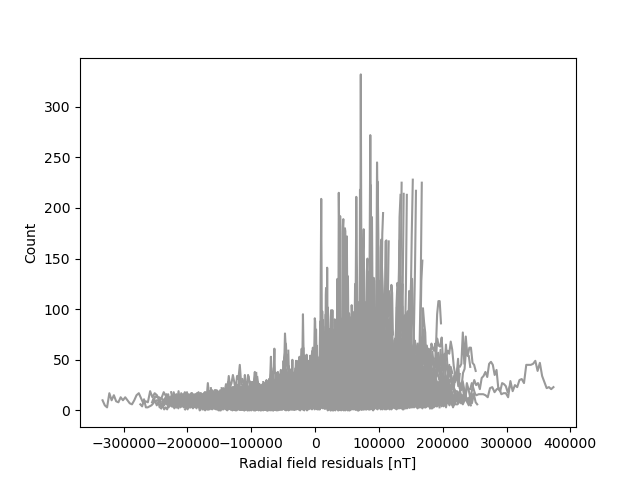

In [17]:
N_sim = 1000
core.target_var = np.max(C_Br_model)
#core.target_var = np.var(core.data)

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        s_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = True, solve_cho = True)

In [18]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shc_grid)

In [19]:
#core.covmod_lsq_equiv(s_sat.data, C_Br_model, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


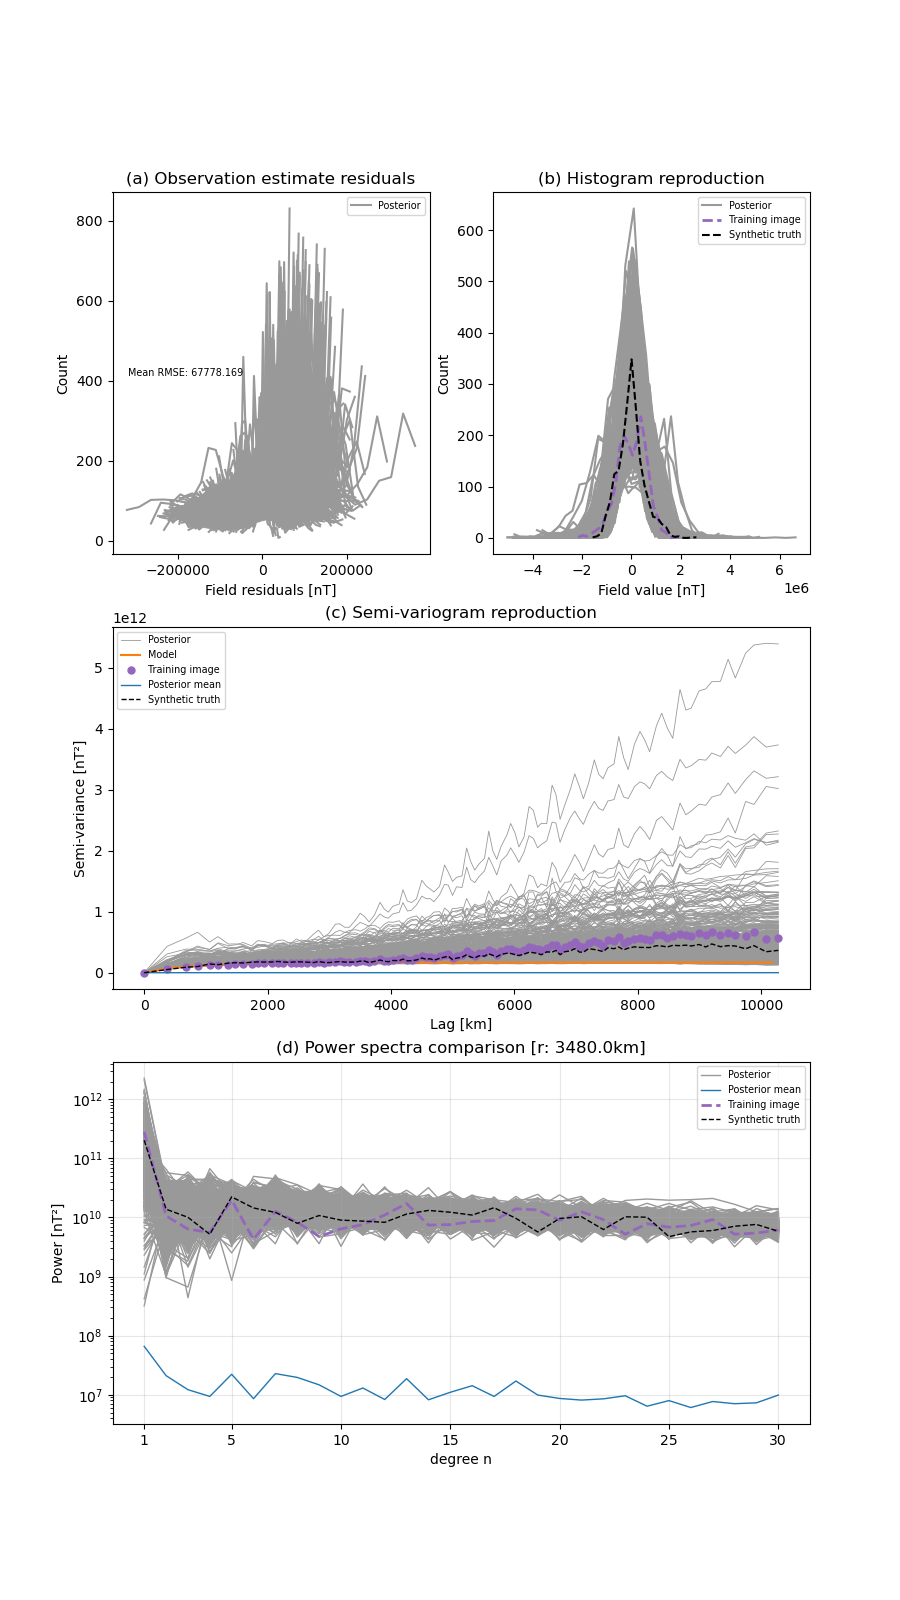

In [20]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = None, truth_obj = s_source,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              model_dict = {}, figsize=(9,16), hist_ti_ens = False, hist_density = False,
                              hist_bins = 25, res_bins = 25, hist_pos_mean = False,
                              savefig = False, save_string = "core_sh30_newTI", save_dpi = 300)

In [21]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


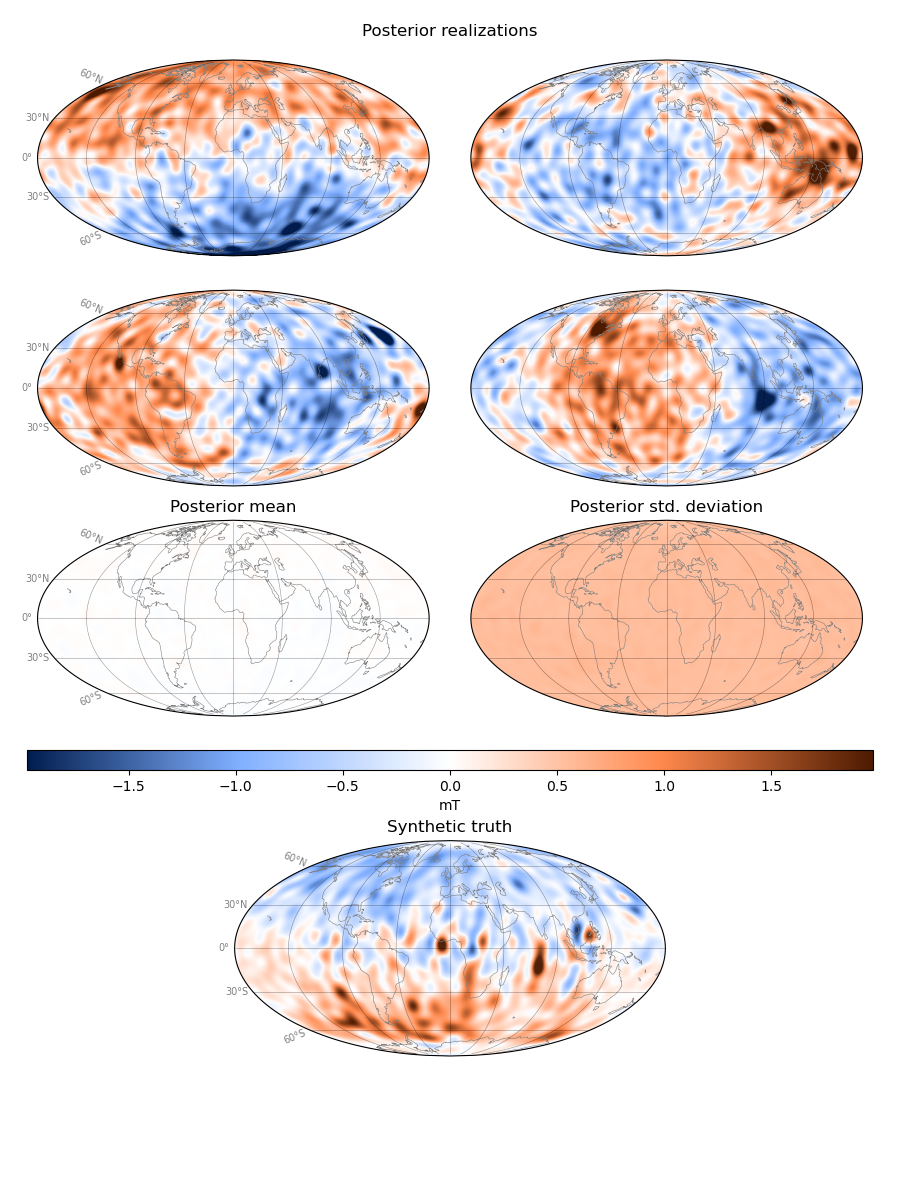

In [22]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 2/3,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "core_sh30_newTI", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)


<IPython.core.display.Javascript object>


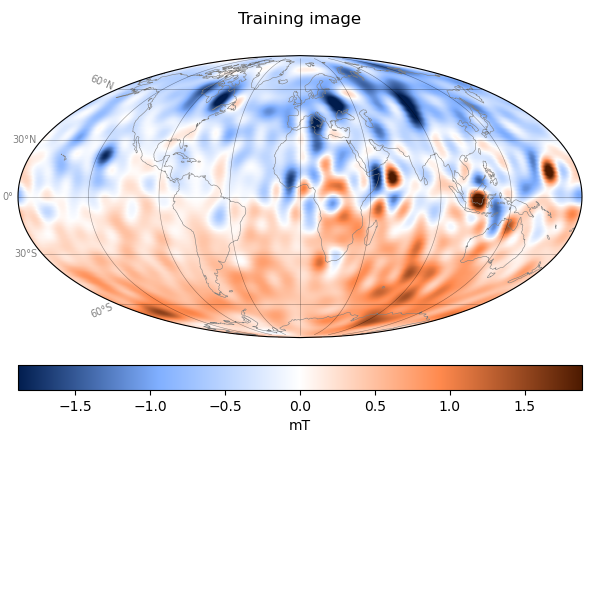

In [79]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
training_image = core.B_ensemble[:,0].copy()

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=training_image, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Training image', point_size=1,
                savefig = False, save_dpi = 100, save_string ="core_sh30_synth_TI",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)